# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'top domains'
n = 10

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [6]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,castle3b7c9f,essential-cb,misskitty-mac,terrestrial-mac,minesweepers-mac,languid-mac,turing-chromebook,dramatic-mac,calcannea-mac,calcannea-cb,...,DESKTOP-PIMD8C0,essential-mac,turing-macbook,MalcomWare-PC,simon-macpro,turing-minimacbook,tirasse-mac,dgmac,LAPTOP-1I501C4U,score
besthearingaids.co.uk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
usa.gov,0,0,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
tso.co.uk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
veoyleztq.openvpn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
digitalocean.com,0,3,6,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,11
officelive.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
iit.edu,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
plista.com,0,4,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
monkeydom.de,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
videmob.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


## Get list of highest accessed domains by all devices

In [7]:
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'trustnetworks.com', 'googleapis.com',
       'apple.com', 'in-addr.arpa', 'clubhouse.io', 'akadns.net',
       'doubleclick.net', 'netgear.com'], dtype=object)

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite domains by device

In [9]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['castle3b7c9f',
  array(['netgear.com', 'besthearingaids.co.uk', 'adsnative.com',
         'dailyuploads.net', 'breathehr.com', 'merklesearch.com',
         'ocado.com', 'stride.com', 'knowlesofworcester.co.uk',
         'holidayinnresorts.com'], dtype=object)],
 ['essential-cb',
  array(['google.com', 'clubhouse.io', 'gstatic.com', 'googleapis.com',
         'slack.com', 'bbc.co.uk', 'trustnetworks.com', 'bbci.co.uk',
         'google.co.uk', 'slack-msgs.com'], dtype=object)],
 ['misskitty-mac',
  array(['google.com', 'akadns.net', 'googleapis.com', 'gstatic.com',
         'apple.com', 'github.com', 'cloudapp.net', 'doubleclick.net',
         'amazonaws.com', 'in-addr.arpa'], dtype=object)],
 ['terrestrial-mac',
  array(['google.com', 'gstatic.com', 'apple.com', 'googleapis.com',
         'in-addr.arpa', 'amazon.com', 'amazonaws.com',
         'googleusercontent.com', 'slack.com', 'clubhouse.io'], dtype=object)],
 ['minesweepers-mac',
  array(['google.com', 'github.com', 'in-addr.ar

In [10]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
castle3b7c9f,"[netgear.com, besthearingaids.co.uk, adsnative..."
essential-cb,"[google.com, clubhouse.io, gstatic.com, google..."
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat..."
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi..."
minesweepers-mac,"[google.com, github.com, in-addr.arpa, clubhou..."
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic...."
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac..."
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar..."
calcannea-mac,"[google.com, googleapis.com, slack.com, crashl..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
minesweepers-mac,"[google.com, github.com, in-addr.arpa, clubhou...",-0.48
tirasse-mac,"[google.com, in-addr.arpa, gstatic.com, clubho...",-1.00
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-1.11
dgmac,"[google.com, apple.com, clubhouse.io, github.c...",-1.17
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-1.17
theatergoing-mac,"[trustnetworks.com, google.com, microsoft.com,...",-1.31
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",-1.48
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-1.51
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",-1.55


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x)).round(2)

In [14]:
df3

,domains,castle3b7c9f,essential-cb,misskitty-mac,terrestrial-mac,minesweepers-mac,languid-mac,turing-chromebook,dramatic-mac,calcannea-mac,...,rarb-mac,DESKTOP-PIMD8C0,essential-mac,turing-macbook,MalcomWare-PC,simon-macpro,turing-minimacbook,tirasse-mac,dgmac,LAPTOP-1I501C4U
device,,,,,,,,,,,,,,,,,,,,,
castle3b7c9f,"[netgear.com, besthearingaids.co.uk, adsnative...",1.00,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,...,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06
essential-cb,"[google.com, clubhouse.io, gstatic.com, google...",-5.06,1.00,-3.25,-2.52,-2.26,-3.27,-1.48,-4.00,-1.48,...,-2.94,-3.13,-4.46,-3.45,-2.95,-2.70,-3.35,-2.23,-1.66,-3.13
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-5.06,-3.25,1.00,-1.65,-0.97,-1.15,-3.25,-2.50,-3.85,...,-2.09,-2.40,-3.64,-1.99,-2.79,-1.49,-1.82,-1.49,-1.65,-2.40
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-5.06,-2.52,-1.65,1.00,-1.24,-0.92,-2.27,-2.28,-3.48,...,-1.70,-3.19,-3.30,-2.33,-3.45,-0.94,-1.59,-0.55,-0.75,-3.19
minesweepers-mac,"[google.com, github.com, in-addr.arpa, clubhou...",-5.06,-2.26,-0.97,-1.24,1.00,-1.05,-2.99,-2.72,-3.61,...,-0.94,-2.48,-3.35,-1.60,-2.72,-1.32,-1.64,0.17,-0.45,-2.48
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-5.06,-3.27,-1.15,-0.92,-1.05,1.00,-2.79,-2.18,-3.95,...,-1.60,-2.68,-3.28,-1.76,-2.90,-1.45,-1.18,-0.88,-1.70,-2.68
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",-5.06,-1.48,-3.25,-2.27,-2.99,-2.79,1.00,-4.00,-2.07,...,-3.03,-3.73,-3.91,-3.55,-3.45,-2.21,-2.90,-2.44,-2.54,-3.73
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar...",-5.06,-4.00,-2.50,-2.28,-2.72,-2.18,-4.00,1.00,-4.45,...,-1.58,-3.56,-2.87,-2.64,-3.91,-3.03,-2.05,-2.87,-2.76,-3.56
calcannea-mac,"[google.com, googleapis.com, slack.com, crashl...",-5.06,-1.48,-3.85,-3.48,-3.61,-3.95,-2.07,-4.45,1.00,...,-3.56,-4.24,-4.46,-4.00,-3.96,-3.45,-4.00,-3.64,-3.61,-4.24


## Plot heatmap

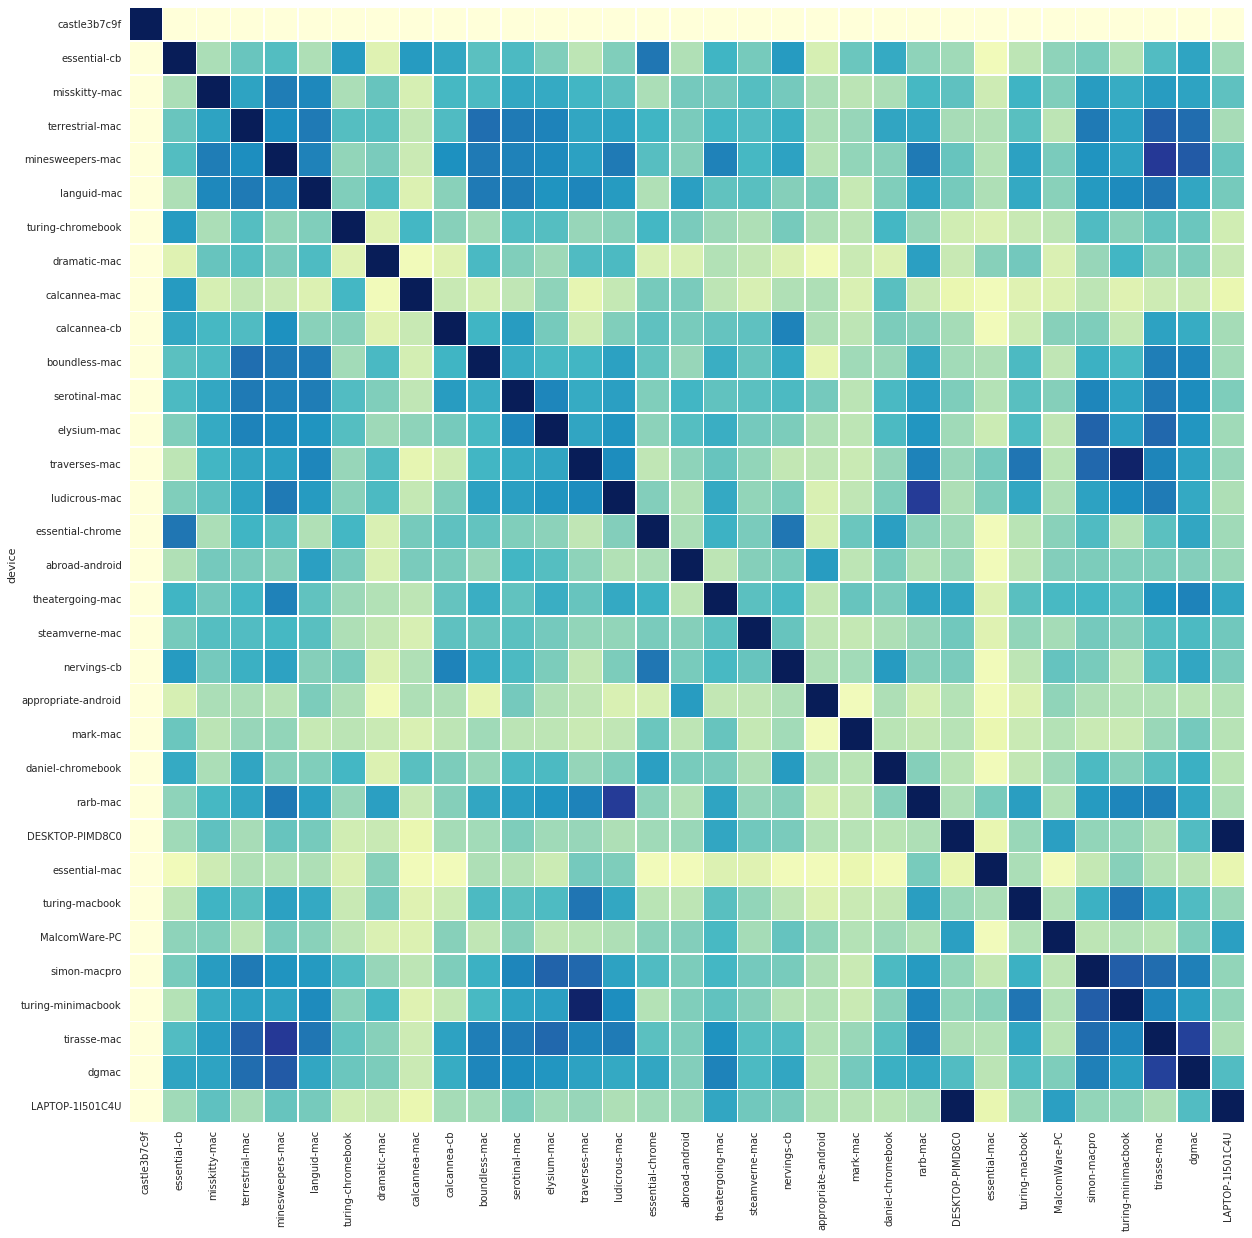

In [15]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()